In [9]:

using Markdown
using InteractiveUtils
using Graphs, Random, Statistics
using Plots, Colors
using ITensors, ITensorMPS, LinearAlgebra
using JLD2 

# seed for reproducibility
Random.seed!(1234);



In [10]:

function create_MPS(L::Int)
    sites = siteinds("S=1/2", L; conserve_qns=true)
    initial_state = [isodd(i) ? "Up" : "Dn" for i in 1:L]
    ψ₀ = randomMPS(sites, initial_state)
    return ψ₀, sites
end



create_MPS (generic function with 1 method)

In [11]:
"""
Creates a weighted adjacency matrix for a completely connected graph.
"""
function create_weighted_adj_mat(N::Int, σ::Float64; μ::Float64=1.0)
    if σ == 0.0
        A = ones(Float64, N, N)
        A -= Matrix{Float64}(I, N, N)
        return A
    end
    A = zeros(Float64, N, N)
    for i in 1:N, j in (i+1):N
        weight = μ + σ * randn()
        A[i, j] = A[j, i] = weight
    end
    return A
end

create_weighted_adj_mat

In [12]:
"""
Creates the MPO for the XXZ Hamiltonian on a graph with weighted interactions.
"""
function create_weighted_xxz_mpo(N::Int, adj_mat, sites; J::Float64, Δ::Float64)
    ampo = OpSum()
    for i in 1:N-1
        for j in i+1:N
            coupling_strength = adj_mat[i, j]
            if coupling_strength != 0.0
                ampo += coupling_strength * (J / 2), "S+", i, "S-", j
                ampo += coupling_strength * (J / 2), "S-", i, "S+", j
                ampo += coupling_strength * (J * Δ), "Sz", i, "Sz", j
            end
        end
    end
    return MPO(ampo, sites)
end

create_weighted_xxz_mpo

In [13]:

function run_simulation_and_plot_delta()

    N_range = 10:2:20 
    delta_range = [-1.0, -0.5, 0.0, 0.5, 1.0] 
    
    
    num_sweeps = 30
    max_bond_dim_limit = 250
    cutoff = 1E-10
    μ = 1.0
    
    σ = 0.0 


    max_bond_dims = zeros(Float64, length(N_range), length(delta_range))


    for (i, N) in enumerate(N_range)
        for (j, Δ_val) in enumerate(delta_range)

            ψ₀, sites = create_MPS(N)
            adj_mat = create_weighted_adj_mat(N, σ; μ=μ)
            H_mpo = create_weighted_xxz_mpo(N, adj_mat, sites; J=-0.5, Δ=Δ_val)

            sweeps = Sweeps(num_sweeps)
            setmaxdim!(sweeps, max_bond_dim_limit)
            setcutoff!(sweeps, cutoff)

            _, ψ_gs = dmrg(H_mpo, ψ₀, sweeps; outputlevel=0)
            
            max_bond_dims[i, j] = maxlinkdim(ψ_gs)
        end
    end


    N_values = collect(N_range)
    delta_values = collect(delta_range)

    plotlyjs() 
    
    # The plot function expects the Z matrix dimensions to be (length(y), length(x))
    # Since our matrix is (length(x), length(y)), we need to transpose it.
    
    plt = plot(N_values, delta_values, max_bond_dims',
        st=:surface,
        title="Maximum Bond Dimension",
        xlabel="System Size",
        ylabel="Δ",  
        zlabel="Maximum Bond Dimension",
        camera=(50, 30),      
        c=cgrad(:inferno),    
        legend=false
    )
    
    return plt, max_bond_dims, N_range, delta_range
end

run_simulation_and_plot_delta (generic function with 1 method)

In [14]:

plt, max_bond_dims, N_range, delta_range = run_simulation_and_plot_delta();



filename = "surface_plot_delta_data.jld2"
jldsave(filename; max_bond_dims, N_range, delta_range)
println("Data saved successfully.\n")










Data saved successfully.



In [15]:
function load_data_and_plot(filename)
    println("Loading data from $filename...")
    if !isfile(filename)
        println("Error: Data file '$filename' not found")
        return nothing
    end
    
    # Load the data from the JLD2 file
    data = load(filename)
    max_bond_dims = data["max_bond_dims"]
    N_range = data["N_range"]
    delta_range = data["delta_range"]

    N_values = collect(N_range)
    delta_range = collect(delta_range)

    plotlyjs() # Ensure plotting backend is active
    
    plt = plot(N_values, delta_range, max_bond_dims',
        st=:surface,
        title="Maximum Bond Dimension",
        xlabel="System Size",
        ylabel="Δ",  
        zlabel="Maximum Bond Dimension",
        camera=(50, 30),      
        c=cgrad(:inferno),    
        legend=false
    )
    
    return plt
end

load_data_and_plot (generic function with 1 method)

--- Loading and Plotting from File ---
Loading data from surface_plot_delta_data.jld2...


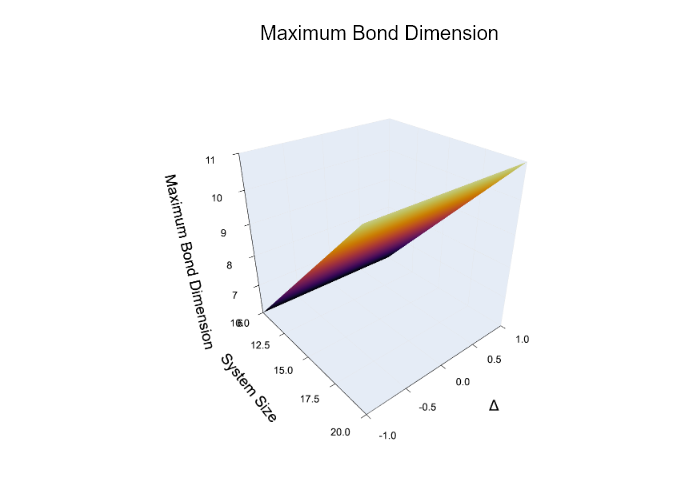

In [16]:
println("--- Loading and Plotting from File ---")
plt = load_data_and_plot(filename)
if plt !== nothing
    display(plt)
end